## Baseline Models
Purpose of this notebook is to implement baseline simple text classification models

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Capstone/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Capstone


In [12]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

import spacy
import nltk
from nltk import word_tokenize
from spacy_preprocessor import SpacyPreprocessor

import string
import re

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix 


from time import time

# other
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

tqdm.pandas()
tqdm_notebook().pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Text Preprocessing

In [5]:
# importing cleaned data
data = pd.read_csv('data/timeless_total_cleaned_df.csv')

## Modeling

In [7]:
X = data.pp_text
y = data.target

display(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10646,)

(10646,)

(7984,) (7984,)
(2662,) (2662,)


In [8]:
count_vect = CountVectorizer() 

X_train_dtm = count_vect.fit_transform(X_train)
X_test_dtm = count_vect.transform(X_test)

print(X_train_dtm.shape, X_test_dtm.shape)

(7984, 537109) (2662, 537109)


### Multinomial Naive Bayes

#### CountVectorizer

In [9]:
nb = MultinomialNB() 
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

CPU times: user 220 ms, sys: 2.65 ms, total: 222 ms
Wall time: 220 ms


Accuracy:  0.628099173553719
ROC_AOC_Score:  0.6533997511730093
F1_Score:  0.630321135175504
Precision:  0.6298507462686567
Recall:  0.6307922272047832


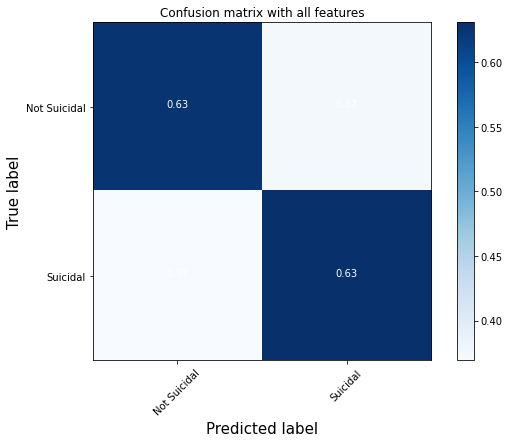

In [15]:
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Suicidal','Suicidal'],normalize=True,
                      title='Confusion matrix with all features')

y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
print("F1_Score: ", f1_score(y_test, y_pred_class))
print("Precision: ", precision_score(y_test, y_pred_class))
print("Recall: ", recall_score(y_test, y_pred_class))

#### CountVectorizer

Retrying with different number (lower) of max_features. 

In [17]:
vect = CountVectorizer(max_features=15_000, ngram_range=(1, 2)) 
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() 
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
print("F1 Score: ", f1_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Suicidal','Suicidal'],normalize=True,\
                      title='Confusion matrix with max 5000 features')

## Logistic Regression

In [18]:
tfidf_vect = TfidfVectorizer(max_features=10_000, ngram_range=(1,2)) 

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)

(7984, 10000) (2662, 10000)


Accuracy:  0.6945905334335086
ROC_AOC_Score:  0.6533997511730093
F1_Score:  0.6974320803870487
Precision:  0.6945885841363973
Recall:  0.7002989536621823


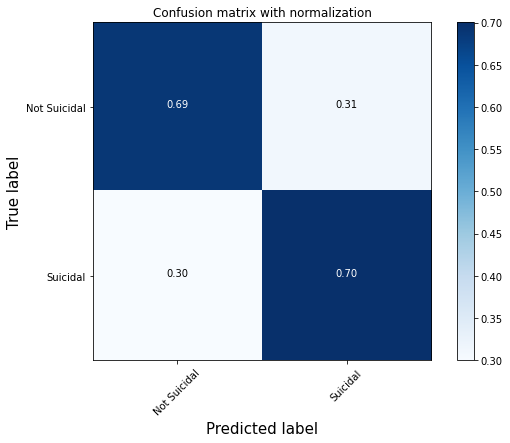

In [19]:
logreg = LogisticRegression(class_weight="balanced") 
logreg.fit(X_train_tfidf, y_train) 

#Make predictions on test data
y_pred_class = logreg.predict(X_test_tfidf)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
print("F1_Score: ", f1_score(y_test, y_pred_class))
print("Precision: ", precision_score(y_test, y_pred_class))
print("Recall: ", recall_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Suicidal','Suicidal'],normalize=True,
                      title='Confusion matrix with normalization')

## SVC

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.6141998497370398
ROC_AOC_Score:  0.6533997511730093
F1_Score:  0.6277636824936571
Precision:  0.609429978888107
Recall:  0.6472346786248132


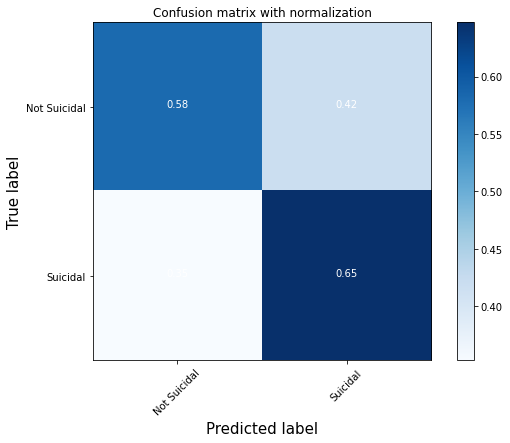

In [25]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
print("F1_Score: ", f1_score(y_test, y_pred_class))
print("Precision: ", precision_score(y_test, y_pred_class))
print("Recall: ", recall_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Suicidal','Suicidal'],normalize=True,
                      title='Confusion matrix with normalization')